**CPLEX installation guide:** Add following line to your `.bash_profile` (for macOS) after installing IBM ILOG CPLEX Optimization Studio locally using installer from IBM. (note the path will change if you are using different python or OS)

```export PYTHONPATH="/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx"```

In [1]:
import cplex
print(cplex.__path__)  # make sure the path is the one we pick above

['C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio1210\\cplex\\python\\3.7\\x64_win64\\cplex']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_choice_to_pref_cost, cal_total_preference, cal_total_accounting,
    nd_ndp1_to_account_penality
)
from util_cost import choices as family_pref
from util_check import deep_check, check_valid_all

## Parameters

In [3]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300
# constants #

# params #
#path_init_conf =     '../output/m08-improved-test.csv'
path_init_conf =     '../input/another_pytorch_implementation.csv'
path_dump_improved = '../output/m14-improved-v2-windows.csv' # output solution

num_cpu_cores = 20
time_limit = -1 # unlimited
#time_limit = 3*60*60*1000  # in ms

occupancy_diff = 30  # +- the occupancy of input solution for each day
max_family_rank = 7  # maximum number of rank of the preference days for each family
use_hint = False      # use current input as hint
occupancy_count_as_variables = True  # use occupancy_counts as variable (seem faster)
min_choice_0_families = 100   # minimum number of families that are at their choice 0
target_pref_cost = 62868
target_pref_cost_error = 0
target_accounting_cost = 0 # 6020.043432
target_accounting_cost_error = 1000

In [4]:
families = range(N_families)
days = range(1, N_days + 1)

In [5]:
#print(list(days))

In [6]:
allowed_occupancy = range(N_min_people, N_max_people + 1)

In [7]:
assigned_day, family_on_day, occupancy = init(path_conf=path_init_conf)
print('Init config:')
try:
    is_valid = deep_check(assigned_day, family_on_day, occupancy)
except:
    is_valid = False
print('Valid solution: ', is_valid)
print('Total score:    ', cal_total(assigned_day, occupancy))
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

Read initial configs...
Read config completed.
Init config:
deep check: everything looks fine.
Valid solution:  True
Total score:     71252.41958450396
Preference cost: 65785
Accounting cost: 5467.419584503968


In [8]:
print(occupancy, occupancy.shape)

[125 300 286 300 300 283 257 244 244 266 293 300 299 276 261 253 268 292
 290 271 244 220 225 250 277 297 289 271 255 245 242 270 273 253 220 193
 162 197 231 254 236 205 176 188 210 248 267 249 223 196 175 212 246 245
 221 185 152 125 219 246 231 201 160 125 125 125 243 214 177 131 125 125
 125 223 201 171 126 125 125 125 222 205 171 125 126 126 125 249 229 199
 157 125 125 125 230 208 175 128 125 125 125 125] (102,)


In [9]:
init_occupancy_counts = {o: 0 for o in allowed_occupancy}
for o in occupancy[1:-1]:
    init_occupancy_counts[o] += 1
init_occupancy_counts = pd.Series(init_occupancy_counts)

In [10]:
pdf = pd.DataFrame(init_occupancy_counts, columns=['counts'])
pdf.index.name = 'occupancy'

In [11]:
#pdf.plot(kind='bar', figsize=(24, 2), grid=True); plt.ylim(-1, 19)

## Setup

In [12]:
# limit the occupancy choice to +- occupancy_diff of current solution
search_occupancy = {}
for day in days:
    search_occupancy[day] = range(max(occupancy[day] - occupancy_diff, N_min_people), 
                                  min(occupancy[day] + occupancy_diff, N_max_people) + 1)

In [13]:
for i, x in search_occupancy.items():
    print(i, x)

1 range(270, 301)
2 range(256, 301)
3 range(270, 301)
4 range(270, 301)
5 range(253, 301)
6 range(227, 288)
7 range(214, 275)
8 range(214, 275)
9 range(236, 297)
10 range(263, 301)
11 range(270, 301)
12 range(269, 301)
13 range(246, 301)
14 range(231, 292)
15 range(223, 284)
16 range(238, 299)
17 range(262, 301)
18 range(260, 301)
19 range(241, 301)
20 range(214, 275)
21 range(190, 251)
22 range(195, 256)
23 range(220, 281)
24 range(247, 301)
25 range(267, 301)
26 range(259, 301)
27 range(241, 301)
28 range(225, 286)
29 range(215, 276)
30 range(212, 273)
31 range(240, 301)
32 range(243, 301)
33 range(223, 284)
34 range(190, 251)
35 range(163, 224)
36 range(132, 193)
37 range(167, 228)
38 range(201, 262)
39 range(224, 285)
40 range(206, 267)
41 range(175, 236)
42 range(146, 207)
43 range(158, 219)
44 range(180, 241)
45 range(218, 279)
46 range(237, 298)
47 range(219, 280)
48 range(193, 254)
49 range(166, 227)
50 range(145, 206)
51 range(182, 243)
52 range(216, 277)
53 range(215, 276)
54

In [14]:
# [Not using this for now]
# occupancy pairs [o, o_next] limited by accounting cost
max_accounting_cost = target_accounting_cost + 10
viable_nd_ndp1 = nd_ndp1_to_account_penality < max_accounting_cost

In [15]:
viable_nd_ndp1[N_min_people:N_max_people+1, N_min_people:N_max_people+1].sum()

4529

(125, 300)

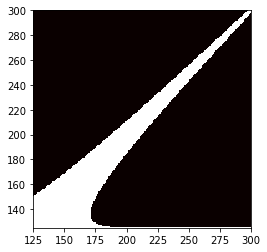

In [16]:
plt.imshow(viable_nd_ndp1, cmap='hot', interpolation='nearest')
plt.xlim(N_min_people, N_max_people)
plt.ylim(N_min_people, N_max_people)

In [17]:
# Possible choice for the family
# last choice is any day that is not on the family's preferred days
N_choices_ori = family_id_choice_to_pref_cost.shape[1]
N_choices = min(N_choices_ori, max_family_rank)
print('Limit family choice rank:', N_choices_ori, '->', N_choices)

Limit family choice rank: 11 -> 7


In [18]:
family_id_choice_to_pref_cost[:, :N_choices]

array([[  0,  50,  86, ..., 236, 272, 372],
       [  0,  50,  86, ..., 236, 272, 372],
       [  0,  50,  77, ..., 227, 254, 354],
       ...,
       [  0,  50, 104, ..., 254, 308, 408],
       [  0,  50,  95, ..., 245, 290, 390],
       [  0,  50,  86, ..., 236, 272, 372]], dtype=int64)

## DOCplex model

In [19]:
from docplex.mp.model import Model

In [20]:
solver = Model('')

In [21]:
if num_cpu_cores > 0:
    solver.context.cplex_parameters.threads = num_cpu_cores
    print('Set num threads:', num_cpu_cores)
print('Num treads:', solver.context.cplex_parameters.threads)
#if time_limit > 0:
#    print('Set time limit:', solver.SetTimeLimit(time_limit))

Set num threads: 20
Num treads: threads:int(20)


## Variables

In [22]:
# Variables
# assignment matrix[family, pref_rank]
assignment_matrix = solver.binary_var_matrix(families, range(N_choices), 'x')

In [23]:
len(assignment_matrix)

35000

In [24]:
possible_family_sizes = np.unique(n_people)

In [25]:
# unpreferred_day_counts[day, size]
if N_choices_ori <= N_choices:
    print('using unpreferred day counts')
    ub = int(N_max_people / possible_family_sizes.min())
    unpreferred_day_counts = solver.integer_var_matrix(days, possible_family_sizes, lb=0, ub=ub, name='d')
    print(len(unpreferred_day_counts))    

In [26]:
# Occupancy matrix [day, N_d, N_d+1]
occupancy_keys_list = []
for day in days:
    if day < N_days:
        for o in search_occupancy[day]:
            for o_next in search_occupancy[day + 1]:
                #if viable_nd_ndp1[o, o_next]:
                occupancy_keys_list.append((day, o, o_next))
    else:
        # last day
        for o in search_occupancy[day]:
            occupancy_keys_list.append((day, o))
occupancy_matrix = solver.binary_var_dict(occupancy_keys_list, name='o')

In [27]:
search_occupancy[N_days]

range(125, 156)

In [28]:
len(occupancy_matrix)

270770

## Constraints

### constraint 1: each family only take one day (choice)

In [29]:
# Constraints
# constraint 1: each family only take one day (choice)
solver.add_constraints_([
    solver.sum([assignment_matrix[family, c] for c in range(N_choices)]) == 1 
    for family in families
])

### constraint: choices limit

In [30]:
if min_choice_0_families > 0:
    solver.add_constraint_(
        solver.sum([assignment_matrix[family, 0] for family in families]) >= min_choice_0_families
    )

### occupancy counts

In [31]:
# constraint 2: each day can only have 125-300 people

In [32]:
N_family_pref = min(N_choices, N_choices_ori - 1)
N_family_pref

7

In [33]:
# day to dictionary of families who choose this day with value as preference rank
days_family_prefered = [{} for day in range(N_days+1)]  # day = 0 should not be used

In [34]:
for family, pref in enumerate(family_pref):
    for rank, day in enumerate(pref):
        if rank < N_family_pref:
            days_family_prefered[day][family] = rank

In [35]:
# occupancy count [intermediate variables]

if occupancy_count_as_variables:
    lbs = [min(search_occupancy[day]) for day in days]
    ubs = [max(search_occupancy[day]) for day in days]
    occupancy_counts = solver.integer_var_dict(days, lb=lbs, ub=ubs, name='oc')
    
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        solver.add_constraint_(
            occupancy_counts[day] == (
                solver.sum(
                    [assignment_matrix[family, pref_rank] * n_people[family] 
                     for family, pref_rank in family_prefered.items()]
                ) + (
                    solver.sum(
                        [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                    ) if N_choices >= N_choices_ori else 0
                )
            )
        )
else:
    occupancy_counts = {}
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        occupancy_counts[day] = (
            solver.sum(
                [assignment_matrix[family, pref_rank] * n_people[family] 
                 for family, pref_rank in family_prefered.items()]
            ) + (
                solver.sum(
                    [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                ) if N_choices >= N_choices_ori else 0
            )
        )

In [36]:
# for day in days:
#     # find those family who like this day
#     solver.Add(occupancy_counts[day] <= N_max_people, 'ub[%i]' % day)
#     solver.Add(occupancy_counts[day] >= N_min_people, 'ub[%i]' % day)

### constraint 3: unpreferred day family count conservation for each family size

In [37]:
# constraint 3: unpreferred day family count conservation for each family size

In [38]:
family_size_to_family_ids = {
    size: np.where(n_people == size)[0] for size in possible_family_sizes
}

In [39]:
if N_choices >= N_choices_ori:
    solver.add_constraints_([
        solver.sum([assignment_matrix[family, N_choices - 1]
                    for family in family_size_to_family_ids[size]])
        == solver.sum([unpreferred_day_counts[day, size] for day in days])
        for size in possible_family_sizes
    ])

### Occupancy boolean matrix normalization

In [40]:
# occupancy boolean matrix normalization
# each day only take 1 occupancy value
for day in days:
    if day < N_days:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o, o_next] 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
        ])
    else:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o] 
            for o in search_occupancy[day]
        ])
    solver.add_constraint_(occupancy_normalization == 1)

### constrain 4: link occupancy boolean matrix to occupancy count

In [41]:
for day in days:
    if day < N_days:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o, o_next] * o for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
        ])
    else:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o] * o for o in search_occupancy[day]
        ])
    solver.add_constraint_(occupancy_counts[day] == sum_from_occupancy_matrix)

In [42]:
# next day occupancy consistency
if True:
    # Approach 1: (faster)
    solver.add_constraints_([
        occupancy_counts[day + 1] == solver.sum([
            occupancy_matrix[day, o, o_next] * o_next for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
        ])
        for day in days if day < N_days
    ])
else:
    # Approach 2: (much slower)
    for day in days:
        if day + 1 < N_days:
            for o in search_occupancy[day+1]:
                solver.add_constraint_(
                    solver.sum(
                        [occupancy_matrix[day, o_other, o] for o_other in search_occupancy[day]]
                    ) == solver.sum(
                        [occupancy_matrix[day + 1, o, o_other] for o_other in search_occupancy[day+2]]
                    )
                )
    for o in search_occupancy[N_days]:
        solver.add_constraint_(
            solver.sum(
                [occupancy_matrix[N_days - 1, o_other, o] for o_other in search_occupancy[N_days - 1]]
            ) == occupancy_matrix[N_days, o]
        )

### Preference cost

In [43]:
family_pref_cost = solver.sum([
    assignment_matrix[family, c] * family_id_choice_to_pref_cost[family, c]
    for family in families for c in range(N_choices)
])

In [44]:
if target_pref_cost > 0:
    if target_pref_cost_error > 0:
        solver.add_constraints_([
            family_pref_cost <= target_pref_cost + target_pref_cost_error,
            family_pref_cost >= target_pref_cost - target_pref_cost_error
        ])
    else:
        solver.add_constraint_(family_pref_cost == target_pref_cost)

for i, (x, y) in enumerate(family_pref_cost.GetCoeffs().items()):
    if i >= 5: 
        break
    print(type(x), x, y)

family_pref_cost.GetCoeffs()[assignment_matrix[0, 1]]

### Accounting cost

In [45]:
accounting_cost = (
    solver.sum([
        occupancy_matrix[day, o, o_next] * nd_ndp1_to_account_penality[o, o_next]
        for day in days if day < N_days
        for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
    ]) +
    solver.sum([
        occupancy_matrix[N_days, o] * nd_ndp1_to_account_penality[o, o]
        for o in search_occupancy[N_days]
    ])
)

In [46]:
if target_accounting_cost > 0:
    solver.add_constraints_([
        accounting_cost <= target_accounting_cost + target_accounting_cost_error,
        accounting_cost >= target_accounting_cost - target_accounting_cost_error
    ])

In [47]:
#accounting_cost.GetCoeffs()[occupancy_matrix[100, 128]]

## Objective

In [48]:
# Objective - Preference cost only as approximation
solver.minimize(accounting_cost)  # family_pref_cost + 

## Hint

In [49]:
if use_hint:
    print('Using hint!')
    solver.SetHint(
        [assignment_matrix[family, c] for family in families for c in range(N_choices)] +
        [
            occupancy_matrix[day, o, o_next] 
            for day in days if day < N_days
            for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
        ] +
        [
            occupancy_matrix[N_days, o] for o in search_occupancy[N_days]
        ] +
        [
            occupancy_counts[day] for day in days
        ] if occupancy_count_as_variables else []
        ,
        [
            float(assigned_day[family] == family_pref[family, c]) 
            for family in families for c in range(N_choices)
        ] +
        [
            float((occupancy[day] == o) and (occupancy[day + 1] == o_next))
            for day in days if day < N_days
            for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
        ] +
        [
            float(occupancy[N_days] == o) for o in search_occupancy[N_days]
        ] +
        [
            float(occupancy[day]) for day in days
        ] if occupancy_count_as_variables else []
    )

## Solve

In [50]:
solver.get_time_limit()

1e+75

In [51]:
print('N of variables (binary, int):', solver.number_of_variables, 
      '(', solver.number_of_binary_variables, ',', solver.number_of_integer_variables, ')')
print('N of constraints:', solver.number_of_constraints)

N of variables (binary, int): 305870 ( 305770 , 100 )
N of constraints: 5401


In [ ]:
%%time
# Solve
sol = solver.solve()

print('Solution status:', solver.get_solve_status())
print('Total cost:', sol.objective_value, sol.get_objective_value())
print("Time:", '%.3f' % solver.get_solve_details().time, "s")

In [ ]:
# 20: 45338.0 OPTIMAL
# 40: 45338.0 OPTIMAL
# 60: 45338.0 FEASIBLE
#100: 45338.0 FEASIBLE
#10h (2h): 43999.0 FEASIBLE

## Solution

In [ ]:
assigned_day_new_raw = np.ones(assigned_day.shape, dtype='int32') * -1
for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
    assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1

In [ ]:
assigned_day_new_raw

In [ ]:
if N_choices >= N_choices_ori:
    unpreferred_day_counts_sol_dict = sol.get_value_dict(unpreferred_day_counts)
    unpreferred_day_counts_sol = {
        size: [0]+[int(unpreferred_day_counts_sol_dict[day, size]) for day in days]
        for size in possible_family_sizes
    }

    print('Unpreferred families slots:')
    {size: sum(counts) for size, counts in unpreferred_day_counts_sol.items()}

In [ ]:
def distribute_unpreferred_day(assigned_day, unpreferred_day_counts_sol, n_people):
    """ Distribute unpreferred day to each family who has -1 day assigned """
    assigned_day = assigned_day.copy()
    unpreferred_days = {size: [] for size in possible_family_sizes}
    for size in possible_family_sizes:
        for day, quota in enumerate(unpreferred_day_counts_sol[size]):
            unpreferred_days[size] = unpreferred_days[size] + [day] * quota
    unpreferred_day_headers = {size: 0 for size in possible_family_sizes}
    for family, (day, size) in enumerate(zip(assigned_day, n_people)):
        if day == -1:
            assigned_day[family] = unpreferred_days[size][unpreferred_day_headers[size]]
            unpreferred_day_headers[size] += 1
    return assigned_day

In [ ]:
if N_choices >= N_choices_ori:
    assigned_day_new = distribute_unpreferred_day(assigned_day_new_raw, unpreferred_day_counts_sol, n_people)
else:
    assigned_day_new = assigned_day_new_raw

In [ ]:
print('N family unpreferred assigned:', (~(assigned_day_new == assigned_day_new_raw)).sum())

In [ ]:
family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)
occupancy_new = assigned_day_to_occupancy(assigned_day_new)

In [ ]:
try:
    is_valid = deep_check(assigned_day_new, family_on_day_new, occupancy_new)
except:
    is_valid = False
print('Valid solution:', is_valid)
print('Total score:    ', cal_total(assigned_day_new, occupancy_new))
print('Preference cost:', cal_total_preference(assigned_day_new))
print('Accounting cost:', cal_total_accounting(occupancy_new))

## Output

In [ ]:
if is_valid:
    dump_conf(assigned_day_new, path_dump_improved)

## Debug

In [ ]:
# [
#     [assignment_matrix[family, c].solution_value() for c in range(N_choices)]
#     for family in range(10)
# ]        

In [ ]:
# if N_choices >= N_choices_ori:
#     print([
#         [unpreferred_day_counts[day, size].solution_value() for size in possible_family_sizes]
#         for day in range(1, 10)
#     ])